# Трифонов Никита Дмитриевич  
### trifonov28rus@gmail.com  
### tg: @qwertypine

# Задание 3: Моделирование пропущенных данных

Задана таблица, содержащая 2701 строку и 128 столбцов. Элементы таблицы – это наблюдаемые индикаторы коммерческой активности 2701 магазинов по отношению к 128 типам товаров. Не все активности наблюдаются, ненаблюдаемые значения заменены 0. Присутствующие ненулевые наблюдения содержат статистические шумы.  

Требуется установить наличие информационной избыточности в измерениях и выполнить прогноз пропущенных значений на основе совокупности имеющихся.  Нужно также оценить точность такого прогноза. Может ли построенная статистическая модель исправить возможные искажения в присутствующих данных?  

Опишите Ваше решение, и приложите, пожалуйста, тексты программ. Если были использованы внешние компоненты и библиотеки, то укажите их. Предпочтителен язык R. Приложение: файл task3.txt.

### План:
* Установить наличие информационной избыточности в измерениях;
* Выполнить прогноз пропущенных значений;
* Оценить точность прогноза.


### FeatureSelector

https://proglib.io/p/feature-selector/

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization
from time import *
from math import fabs
from scipy.stats import invgauss
import scipy
import random
import json
import math
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import seaborn as sns
%matplotlib inline

# задаем для воспроизводимости результатов
np.random.seed(42)

import filecmp
import os
import subprocess
import tempfile
import librosa
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytest
import seaborn as sb
import tqdm

Using TensorFlow backend.


## Разведочный анализ данных

In [2]:
#работа с датасетом
df3 = pd.read_csv('/home/user/Programs/Svyaznoy/task3.txt', encoding = "ISO-8859-1", sep='\t', header=None)

In [3]:
df3

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.842713,0.171253,0.228401,0.000000,0.000000,0.000000,0.042432,0.107107,0.000000,0.124601,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.213799,0.045314,0.000000,0.000000,0.000000,0.000000,0.000000,0.066943,0.066691,0.099761,...,0.039574,0.0,0.000000,0.110862,0.000000,0.028171,0.000000,0.0,0.000000,0.0
2,0.791006,0.160917,0.105361,0.018976,0.000000,0.029412,0.000000,0.036854,0.000000,0.000000,...,0.022175,0.0,0.000000,0.019536,0.028023,0.000000,0.000000,0.0,0.000000,0.0
3,0.111111,0.144942,0.000000,0.000000,0.062031,0.000000,0.000000,0.045815,0.000000,0.070489,...,0.087092,0.0,0.060019,0.061228,0.019928,0.061066,0.000000,0.0,0.000000,0.0
4,0.166667,0.024771,0.111111,0.000000,0.000000,0.000000,0.000000,0.034540,0.000000,0.000000,...,0.000000,0.0,0.000000,0.056504,0.017544,0.025580,0.041235,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.183158,0.0
2697,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.096596,0.0
2698,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.143809,0.0
2699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0


In [4]:
final = df3.replace(0, np.nan)

Заменим 0 на NaN, чтобы не учитывать нули при подсчете статистики.

## 1. Информационная избыточность в измерениях

### Перекрестная зависимость

### Матрица корреляций (корреляция по модулю)

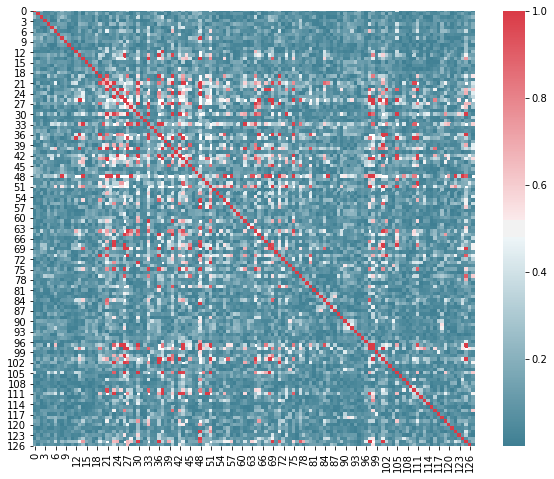

In [5]:
f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(np.abs(final.corr()),
            mask=np.zeros_like(np.abs(final.corr()), dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


Посмотрим теперь на число пропусков:

Text(0, 0.5, 'число примеров (из 2700)')

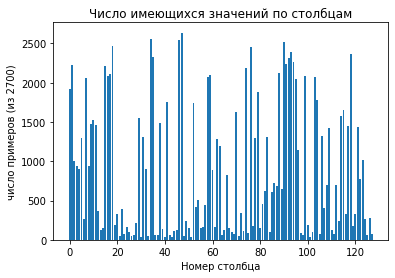

In [6]:
plt.bar(range(128),final.describe().iloc[0])
plt.title('Число имеющихся значений по столбцам')
plt.xlabel('Номер столбца')
plt.ylabel('число примеров (из 2700)')

Как видно, у нас много пропусков, но при это достаточно высокая корреляция между некоторыми признаками.

Установим, какие признаки коллинеарны между собой.

Для этого воспользуемся классом FeatureSelector, ссылка на gihub:  
https://github.com/WillKoehrsen/feature-selector/blob/master/feature_selector/feature_selector.py

Поробное описание:  
https://proglib.io/p/feature-selector/

In [7]:
%run ./FeatureSelector.ipynb

In [8]:
fs = FeatureSelector(data = final)

No labels provided. Feature importance based methods are not available.


In [9]:
fs.identify_collinear(correlation_threshold = 0.95)

36 features with a correlation magnitude greater than 0.95.



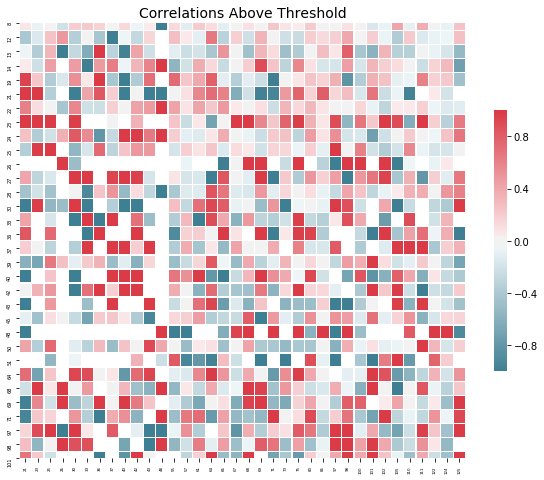

In [10]:
fs.plot_collinear()

Как видно, 36 признаков имеют корреляцию более 0.95, это подтверждает информационнную избыточность.  
Но мы оставим эти данные для дальнейшего предсказания значений моделью - корреляция в данном случае будет иметь значение.

Далее идет дополнительный анализ данных, на этом информационная избыточность установлена.  
Следующая часть под цифрой 2.

## Тепловая карта пропущенных значений

Text(0.5, 1, 'Желтый - пропущенные, синий - не пропущенные')

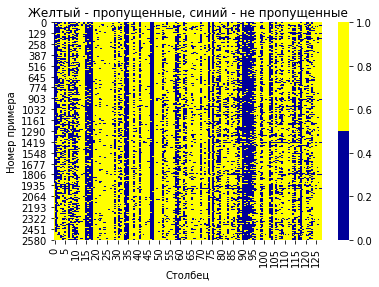

In [11]:
cols = df3.columns[:]
# определяем цвета 
# желтый - пропущенные данные (0), синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df3[cols]==0, cmap=sns.color_palette(colours))
plt.xlabel('Столбец')
plt.ylabel('Номер примера')
plt.title('Желтый - пропущенные, синий - не пропущенные')

### Анализ столбцов

In [12]:
((df3 == 0).sum(axis=0)/27).mean

<bound method Series.mean of 0      29.111111
1      17.481481
2      62.666667
3      65.000000
4      66.740741
         ...    
123    62.444444
124    90.000000
125    97.740741
126    89.925926
127    97.259259
Length: 128, dtype: float64>

В среднем 30% значений в столбцах пропущено.

Text(0, 0.5, 'Процент пропусков')

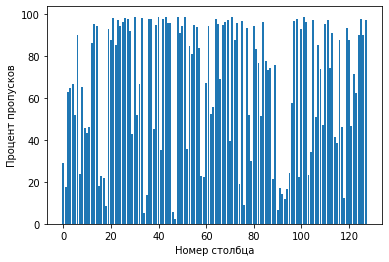

In [13]:
plt.bar(range(128),(df3 == 0).sum(axis=0)/27)
plt.xlabel('Номер столбца')
plt.ylabel('Процент пропусков')

In [14]:
perc = [10, 20, 30,40,50,60,70, 80, 90, 95, 97, 98]
Y = [] #число столбцов, в которых пропущенны хначения, в процентах
for i in perc:
    
    Y.append(len(np.where(((df3 == 0).sum(axis=0)/27)>i)[0])/1.28)

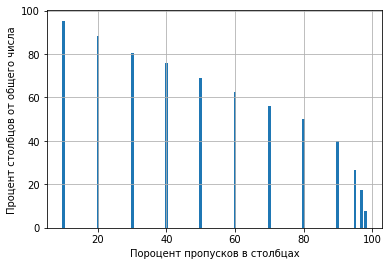

In [15]:
plt.bar(perc, Y)
plt.ylabel('Процент столбцов от общего числа')
plt.xlabel('Пороцент пропусков в столбцах')
plt.grid()

Какой процент откинуть?

### Аналогично для строк

In [16]:
((df3 == 0).sum(axis=1)/1.28).mean

<bound method Series.mean of 0       75.78125
1       67.96875
2       67.18750
3       67.18750
4       74.21875
          ...   
2696    92.96875
2697    92.96875
2698    92.18750
2699    94.53125
2700    94.53125
Length: 2701, dtype: float64>

В среднем 75% значений в строках пропущено

<BarContainer object of 2701 artists>

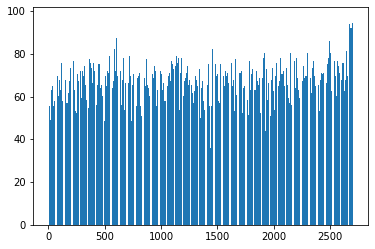

In [17]:
plt.bar(range(2701),(df3 == 0).sum(axis=1)/1.28)

In [18]:
perc1 = [10, 20, 30,40,50,60,70, 80, 90, 95, 97, 98]
Y1 = [] #число столбцов, в которых пропущенны значения, в процентах
for i in perc:
    
    Y1.append(len(np.where((df3 == 0).sum(axis=1)/1.28>i)[0])/27)

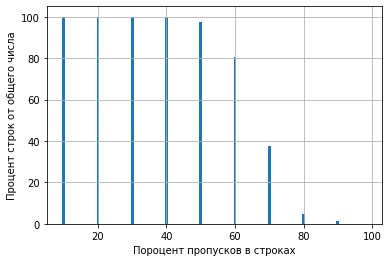

In [19]:
plt.bar(perc1, Y1)
plt.ylabel('Процент строк от общего числа')
plt.xlabel('Пороцент пропусков в строках')
#plt.xticks(perc)
plt.grid()

## Поиск выбросов

In [20]:
final.describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,1915.000000,2229.000000,1009.000000,946.000000,899.000000,1293.000000,267.000000,2054.000000,942.000000,1469.000000,...,2364.000000,181.000000,331.000000,1439.000000,775.000000,1015.000000,271.000000,62.000000,273.000000,75.000000
mean,0.178952,0.063658,0.102983,0.043474,0.053407,0.051178,0.060019,0.050661,0.120012,0.089079,...,0.083900,0.058923,0.054131,0.043872,0.030770,0.059721,0.036340,0.071611,0.066537,0.056024
std,0.155860,0.040891,0.062305,0.025654,0.034292,0.032547,0.038525,0.030722,0.083422,0.056176,...,0.067241,0.036218,0.035112,0.025957,0.014428,0.038939,0.017295,0.054128,0.044764,0.034918
min,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.018182,0.017544,...,0.017544,0.017857,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544
25%,0.074108,0.033769,0.066667,0.025472,0.028651,0.026259,0.032713,0.030402,0.064416,0.050723,...,0.038024,0.031441,0.032693,0.028536,0.022175,0.034813,0.024324,0.039226,0.035091,0.035075
50%,0.133333,0.051578,0.080043,0.037288,0.043934,0.042410,0.049036,0.040774,0.095310,0.074108,...,0.064799,0.048924,0.045117,0.035212,0.026668,0.048013,0.032096,0.061094,0.052632,0.045904
75%,0.221079,0.083736,0.125000,0.052097,0.063596,0.064085,0.073617,0.064108,0.160171,0.105361,...,0.107972,0.074108,0.063732,0.052330,0.035212,0.069720,0.042061,0.087012,0.087012,0.058716
max,1.500000,0.295205,0.668911,0.230837,0.310912,0.301148,0.263078,0.293245,0.696788,0.468750,...,0.708201,0.223144,0.312852,0.216380,0.122950,0.297937,0.134110,0.377990,0.264024,0.188249


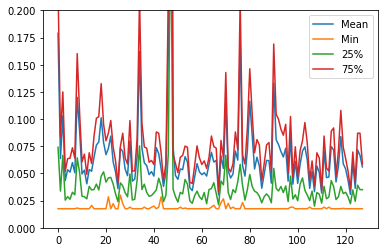

In [21]:
plt.plot(final.describe().iloc[1], label='Mean')
plt.plot(final.describe().iloc[3], label='Min')
plt.plot(final.describe().iloc[4], label='25%')
plt.plot(final.describe().iloc[6], label='75%')
plt.ylim(0,0.2)
plt.legend()

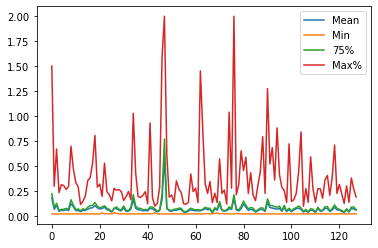

In [22]:
plt.plot(final.describe().iloc[1], label='Mean')
plt.plot(final.describe().iloc[3], label='Min')
plt.plot(final.describe().iloc[6], label='75%')
plt.plot(final.describe().iloc[7], label='Max%')
plt.legend()

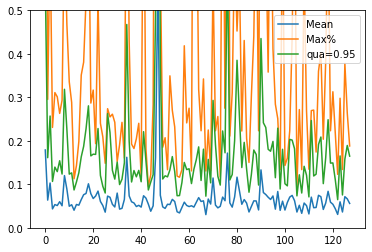

In [23]:
plt.plot(final.describe().iloc[1], label='Mean')
plt.plot(final.describe().iloc[7], label='Max%')
plt.plot(final.quantile(q=0.97),label='qua=0.95')
plt.ylim(0,0.5)
plt.legend()

Узнаем количестви примеров, чье значение по столбцам превышает определенный квантиль, далее, при адекватном количестве (не слишком большом) эти данные можно отбросить.

### Дубликаты

In [24]:
# отбрасываем неуникальные строки
df_dedupped = df3.drop_duplicates()
# сравниваем формы старого и нового наборов
print(df3.shape)
print(df_dedupped.shape)

(2701, 128)
(2701, 128)


Дубликатов нет.

## Неинформативные признаки

In [25]:
num_rows = len(df3.index)
low_information_cols = []
for col in df3.columns:
    cnts = df3[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        #print(cnts)
        print()

13: 95.52018%

21: 98.18586%

23: 97.03813%

25: 96.14957%

26: 98.22288%

27: 97.88967%

30: 98.74121%

33: 98.18586%

36: 97.81562%

37: 97.66753%

40: 98.77823%

42: 97.63051%

43: 98.48204%

44: 96.00148%

45: 95.55720%

48: 98.40800%

51: 98.48204%

64: 97.51944%

65: 95.18697%

68: 96.14957%

69: 97.29730%

71: 98.40800%

73: 95.89041%

75: 96.70492%

84: 96.11255%

97: 96.63088%

98: 97.66753%

101: 98.59311%

102: 96.33469%

105: 97.44539%

110: 95.29804%

111: 97.11218%

125: 97.70455%

127: 97.22325%



In [26]:
len(low_information_cols)

34

В 34 колонках пропущенно более 95% значений, можем принять их как неинформативные.

## 2. Прогноз пропущенных значений

### Основные способы прознозирования

* ___Замена с помощью метода ближайших соседей___  

    Из предположения о том, что близкие объекты по значениям среди заполненныхпризнаков близки в признаках, значение которых может быть пропущено (гипотезакомпактности), возникает применение метода k ближайших соседей для восстановленияпропусков в данных. Реализация аналогична использованию классичесокого методаk ближайших соседей за исключением того, предсказывается сразу несколькопропущенных признаков для каждого объекта.
 
 
* ___Замена с помощью случайного леса___  

    Заменить пропущенные значения в конкретном признаке можно, предсказав его по другим признакам с помощью одного из алгоритмов машинного обучения. Так как среди признаков, по которым производится обучение, имеются пропущенные значения, то необходимо их изначально заменить с помощью одного из простейших методов восстановления пропусков.
    
    
* ___Замена с помощью линейной регрессии___  

    Используется стратегия, аналогичная предыдущему методу, за исключением того,что вместо случайного леса используется линейная регрессия. 
    
    
* ___Замена с помощью метода k средних___  

    Аналогично методу k ближайших соседей предполагается, что близкие по однимпризнакам объекты должны быть близки и по другим признакам. Однако в отличиеот метода k ближайших соседей ищутся не ближайшие соседи для каждого объектас пропущенными значениями, а используется информация о центре кластера, вкоторый попал конкретный объект с пропускам.  Заметим, что для разбиения накластеры необходима начальная инициализация пропущенных значений.  
    В данном случае выполняется инициализация пропущенных значений с помощьюзамены средним значением по признаку, кластеризация производится методом k средних. Пропущенные значения заменяются на соответствующие им значенияцентра кластера, в который попал каждый объект с пропусками. Данная процедурапроизводится в течение нескольких итераций до сходимости или по достижениюмаксимального заданного числа итераций

Существуют и другие способы замены, такие как EM-алгоритмы, k-средние и т.д. Здесь рассмотрены основные.

Далее рассмотрим Линейную регрессию.  

___Идея:___ делим выборку на тренировочную и тестовую случайным образом, в отношнении 80 и 20 процентов соответственно. 
Заменяем неизвестные значения на средние по тренировочной выборке.  
Тестовую выборку будем использовать только для оценки.

* Линейная регрессия  
Обозначаем один из столбцов как прогнозируемый столбец, остальные - как признаки и обучим регрессионную модель прогнозировать данный столбец. Итерации продолжаются для всех столбцов.

__Способ оценки:__ САО, ищем разницу между известными значениями в тестовой выборке и прогнозируемыми.  
Также, для анализа адекватности решения, найдем ошибку между известными значениями тестовой выборки и средними значениями по столбцу, определенными на тренировочном наборе.


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(final, test_size=0.2, random_state=42)

In [28]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,1527.000000,1770.000000,794.000000,744.000000,717.000000,1028.000000,205.000000,1635.000000,741.000000,1176.000000,...,1884.000000,138.000000,273.000000,1173.000000,613.000000,821.000000,215.000000,50.000000,217.000000,64.000000
mean,0.178914,0.063543,0.101311,0.043394,0.053139,0.050854,0.058536,0.050584,0.119962,0.088881,...,0.083641,0.060160,0.054907,0.043609,0.030530,0.060291,0.037891,0.070344,0.067204,0.057099
std,0.158657,0.041139,0.060169,0.025634,0.033718,0.032219,0.036685,0.030424,0.084932,0.056630,...,0.066062,0.036844,0.033283,0.026259,0.014448,0.038399,0.018487,0.055685,0.045899,0.037010
min,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.018182,0.017544,...,0.017544,0.018182,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544
25%,0.074108,0.033734,0.066667,0.025436,0.028536,0.025982,0.031734,0.031174,0.064539,0.051185,...,0.038024,0.031879,0.034298,0.028531,0.021204,0.036009,0.024541,0.037017,0.035081,0.035083
50%,0.133333,0.051738,0.080043,0.037825,0.043806,0.041964,0.048189,0.040774,0.095310,0.074108,...,0.065700,0.050108,0.046215,0.035212,0.026142,0.048949,0.034139,0.062214,0.053841,0.045747
75%,0.214560,0.082449,0.121287,0.051923,0.063549,0.063797,0.074108,0.063070,0.160131,0.104873,...,0.105166,0.074108,0.064264,0.051172,0.034825,0.070744,0.042560,0.087012,0.087012,0.061500
max,1.500000,0.295205,0.668911,0.230837,0.238154,0.227390,0.245112,0.293245,0.696788,0.468750,...,0.514357,0.223144,0.230915,0.216380,0.122950,0.297937,0.134110,0.377990,0.264024,0.188249


In [29]:
MEAN = X_train.describe().iloc[1,:] #средние значения по столбцам

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [32]:
MAE_model = []
MAE_mean = []

for i in range(final.shape[1]-1):
    
    # датасеты для обучения моделей линейной регрессии, убираем столбце с ответами
    X_train_LR = X_train.drop([i], axis='columns', inplace=False)
    X_test_LR = X_test.drop([i], axis='columns', inplace=False)
    
    Y_train_LR = X_train.iloc[:,i]
    Y_test_LR = X_test.iloc[:,i]
    
    #среднее без данного значения
    MEAN1 = MEAN.drop(MEAN.index[[i]]) 
    
    #теперь заменим пропущенные значения на средние по тренировочной выборке        
    X_train_LR = X_train_LR.fillna(MEAN1, inplace=False)
    X_test_LR = X_test_LR.fillna(MEAN1, inplace=False)
    
    Y_train_LR = Y_train_LR.fillna(MEAN1.iloc[i], inplace=False)
    Y_test_LR = Y_test_LR.fillna(MEAN1.iloc[i], inplace=False)
    
    
    reg = LinearRegression().fit(X_train_LR, Y_train_LR)
    pred = reg.predict(X_test_LR)
    
    
    MEAN_column = [MEAN1.iloc[i] for j in range(541)]
    
    MAE_model.append(mean_absolute_error(pred, Y_test_LR))
    MAE_mean.append(mean_absolute_error(MEAN_column, Y_test_LR))

Text(0.5, 1.0, 'Средняя абсолютная ошибка для прогнозирования каждой ошибки')

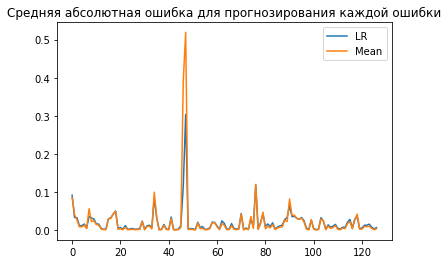

In [35]:
plt.plot(range(len(MAE_model)),MAE_model, label='LR')
plt.plot(range(len(MAE_mean)),MAE_mean, Label='Mean')
plt.legend()
plt.title('Средняя абсолютная ошибка для прогнозирования каждой ошибки')

In [34]:
print('САО по всем столбцам для LR: ', np.mean(MAE_model))
print('САО по всем столбцам для mean: ', np.mean(MAE_mean))

САО по всем столбцам для LR:  0.018828576876056602
САО по всем столбцам для mean:  0.02107412931582691


Как видно, прогнозирование, основанное на линейной регрессии дает меньшую ошибку (по всем столбцам).  
На этом начальное рассмотрение закончено.